# Data Exploration for [C,H]-NMR Shifts

This notebook includes a brief exploration of the NMR datasets for both the C-NMR and H-NMR spectra. The notebook is organized as follows:
 - Imports and Helper Functions
 - Reading and Splitting NMR Data Sets
 - Investigating Flagged Duplicated Molecules in [C,H]-NMR Datsets
     * Are these flagged "duplicates" truly stereochemically equivalent?
     * Are the Spectra of the duplicated molecules the same?
 - Calculating Number of Stereoisomer Sets in Each Dataset
     * Comparing Spectra of Stereoisomers
 - Investigating Distributions of Molecular Descriptors in Each Dataset
 

## Imports and Helper Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import gzip
import pandas as pd
import math

import rdkit # development used rdkit version 2020.09.4
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
from rdkit.Chem import rdMolDescriptors

In [2]:
def draw_molecules_from_smiles(list_smiles):
    mols = [rdkit.Chem.MolFromSmiles(i) for i in list_smiles]
    return rdkit.Chem.Draw.MolsToGridImage(mols)

## Reading and Splitting NMR-Data

In [41]:
data_path = 'nmrshiftdb_chiral_curated1.pickle.gz'
with gzip.open(data_path, 'rb') as f:
    data_df = pd.DataFrame(pickle.load(f))
    
# Splitting into C-Spectrum and H-Spectrum Datasets
data_df_H = data_df[data_df['spectrum_H'].apply(lambda x: isinstance(x, list))]
data_df_C = data_df[data_df['spectrum_C'].apply(lambda x: isinstance(x, list))]

Because every molecule in the dataset does not have both a C-NMR spectrum and an H-NMR spectrum, we split the datasets into two groups: 
 - a datset for every molecule with a C-spectrum
 - a dataset for every molecule with an H-spectrum.

There is a slight overlap in these datasets -- 182 molecules have both types of spectra

### Simple Features of Datasets

In [43]:
print(f'''
Total Number of Rows in Full DataFrame: {len(data_df)}
Total Number Rows in C-Spectra DataFrame: {len(data_df_C)}
Total Number of Rows in H-Spectra DataFrame: {len(data_df_H)}
''')

# Example Row

print('EXAMPLE ROW:')
print('------------')
print(data_df.iloc[0])


Total Number of Rows in Full DataFrame: 5570
Total Number Rows in C-Spectra DataFrame: 3002
Total Number of Rows in H-Spectra DataFrame: 2750

EXAMPLE ROW:
------------
SMILES                BrC(Br)=C[C@@H]1C(C)(C)[C@@H]1C(O[C@@H](c1cc(O...
spectrum_C            [-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...
spectrum_H            [-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...
Solvent_C                                                   Unreported 
Solvent_H                                                   Unreported 
nmrshiftdb2 ID                                                 20208531
ROMol                 \n     RDKit          2D\n\n 28 30  0  0  0  0...
C_valid                                                            True
H_valid                                                            True
num_chiral                                                            3
num_labeled_chiral                                                    3
MW                                    

## Investigating Duplicated Molecules

We want to know whether each row corresponds to a unique (chemically and stereochemically) molecule. It turns out this is not the case.
 - There are 6 instances of duplicated pairs of molecules in the C-spectrum dataset.
 - There are 2 instances of duplicated pairs of molecules in the H-spectrum dataset.

Index-IDs of duplcated molcules in C-dataset:
 [[9808, 9813], [19828, 20687], [7165, 20049], [9230, 10192], [9233, 9735], [24102, 30137]]


<ipython-input-50-cd1062f55027>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_C['canonical_SMILES'] = [rdkit.Chem.CanonSmiles(data_df_C.SMILES.iloc[i]) for i in range(len(data_df_C))]


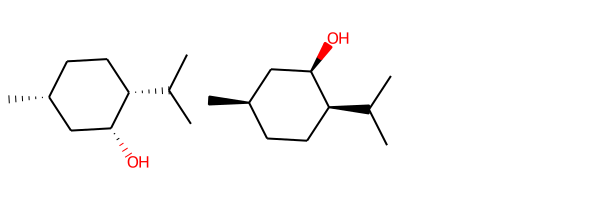

In [50]:
# There are 6 instances of duplicated pairs of molecules in the C-spectrum dataset.

data_df_C['canonical_SMILES'] = [rdkit.Chem.CanonSmiles(data_df_C.SMILES.iloc[i]) for i in range(len(data_df_C))]
df = data_df_C[['SMILES','canonical_SMILES']]
df = df[df['canonical_SMILES'].duplicated(keep=False)]
duplicated_smiles_C = df.groupby(list(df.canonical_SMILES)).apply(lambda x: list(x.SMILES)).tolist()
duplicated_smiles_indices_C = df.groupby(list(df.canonical_SMILES)).apply(lambda x: list(x.index)).tolist()

print(f"Index-IDs of duplcated molcules in C-dataset:\n {duplicated_smiles_indices_C}")

# Example of a duplicated molecule from C-dataset that are equivalent upon rotation
draw_molecules_from_smiles(duplicated_smiles_C[1]) # change this index (0-5) to see more

Index-IDs of duplcated molcules in H-dataset:
 [[30498, 30499], [12997, 23894]]


<ipython-input-66-58849f73a919>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_H['canonical_SMILES'] = [rdkit.Chem.CanonSmiles(data_df_H.SMILES.iloc[i]) for i in range(len(data_df_H))]


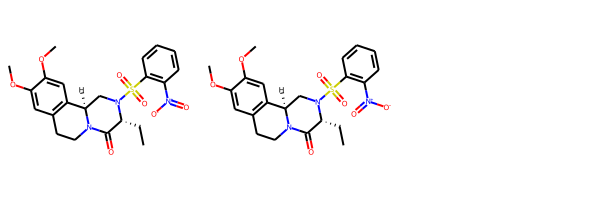

In [66]:
# There are 2 instances of duplicated pairs of molecules in the H-spectrum dataset.

data_df_H['canonical_SMILES'] = [rdkit.Chem.CanonSmiles(data_df_H.SMILES.iloc[i]) for i in range(len(data_df_H))]
df = data_df_H[['SMILES','canonical_SMILES']]
df = df[df['canonical_SMILES'].duplicated(keep=False)]
duplicated_smiles_H = df.groupby(list(df.canonical_SMILES)).apply(lambda x: list(x.SMILES)).tolist()
duplicated_smiles_indices_H = df.groupby(list(df.canonical_SMILES)).apply(lambda x: list(x.index)).tolist()

print(f"Index-IDs of duplcated molcules in H-dataset:\n {duplicated_smiles_indices_H}")

# Example of a duplicated molecule from C-dataset that are equivalent upon rotation
draw_molecules_from_smiles(duplicated_smiles_H[0]) # change this index (0-1) to see more

### Should we filter out any of these duplicated molecules? 
#### Considerations:
 - Are the recorded spectra of the duplicated molecules the same?
 - Do any of the duplicated molecules have both C- and H- spectra?

No handles with labels found to put in legend.


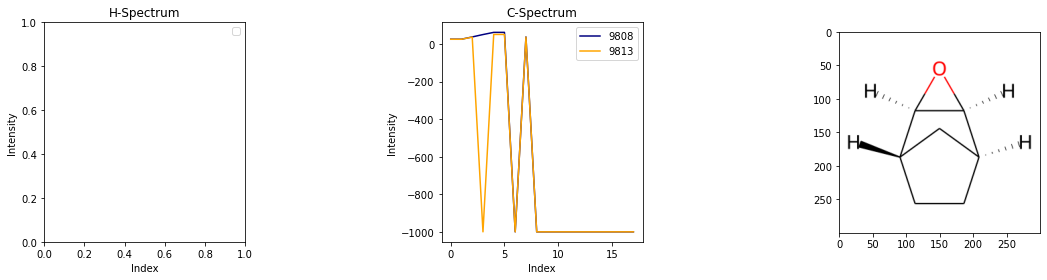

No handles with labels found to put in legend.


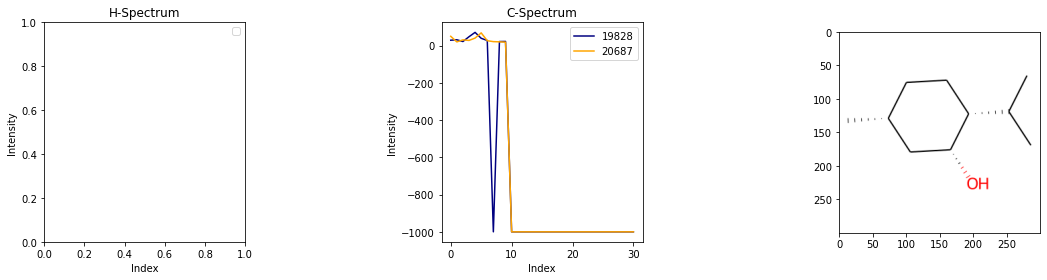

No handles with labels found to put in legend.


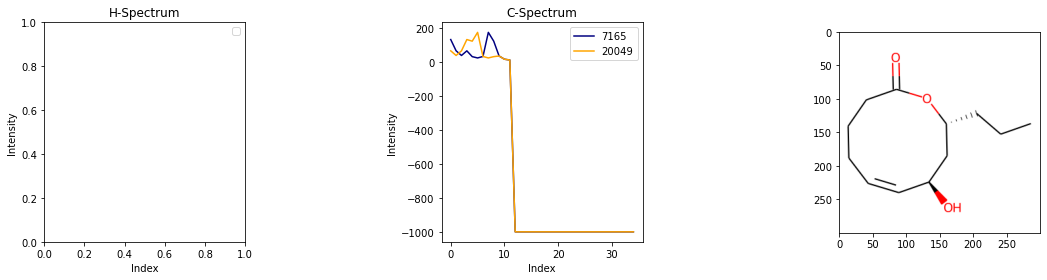

No handles with labels found to put in legend.


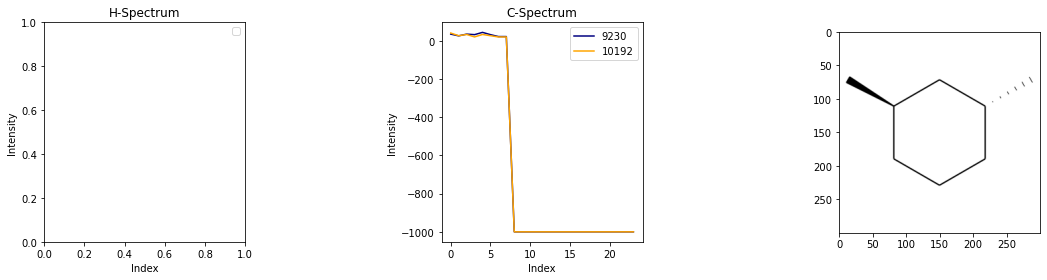

No handles with labels found to put in legend.


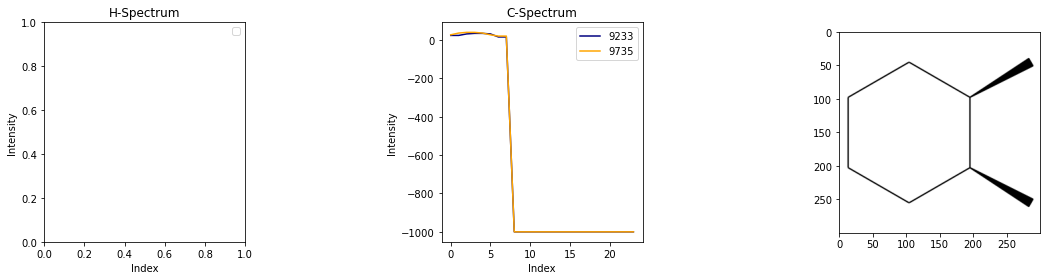

No handles with labels found to put in legend.


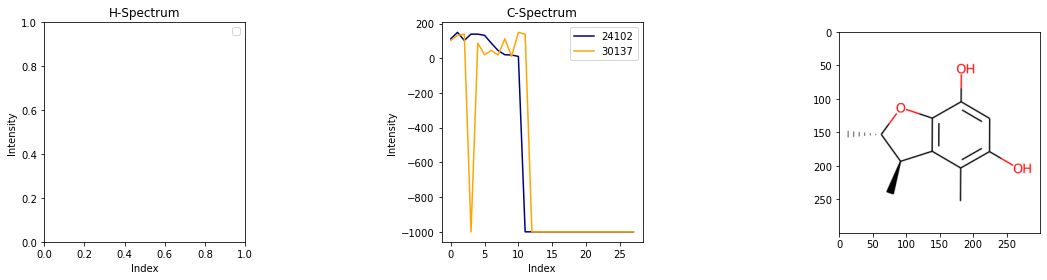

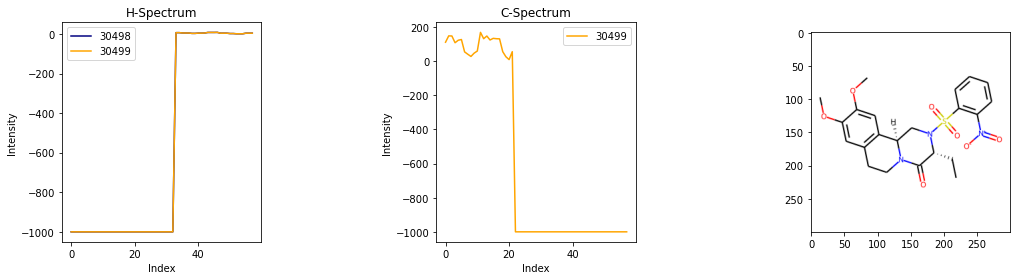

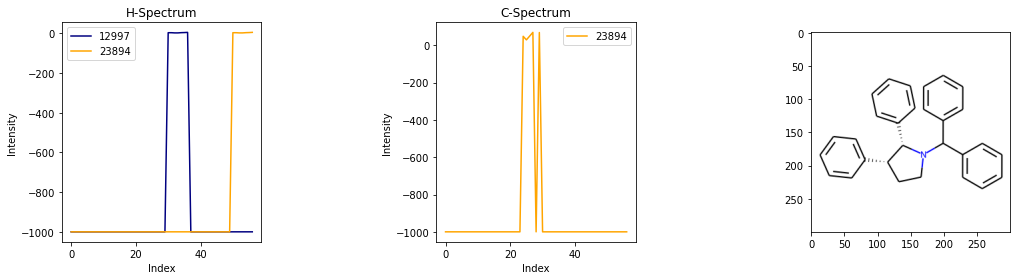

In [7]:
# Do the duplicated molecules have measurably different spectra?

colors = ['navy', 'orange', 'green']
for i in (duplicated_smiles_indices_C + duplicated_smiles_indices_H):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    for j in range(len(i)):   
        mol = rdkit.Chem.MolFromSmiles(data_df.loc[i[0]].SMILES)
        if isinstance(data_df.loc[i[j]].spectrum_H, list):
            ax[0].plot(data_df.loc[i[j]].spectrum_H, label = str(i[j]), color = colors[j])
        if isinstance(data_df.loc[i[j]].spectrum_C, list):
            ax[1].plot(data_df.loc[i[j]].spectrum_C, label = str(i[j]), color = colors[j])
        img = rdkit.Chem.Draw.MolToImage(mol)
        ax[2].imshow(img)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Intensity')
    ax[1].set_xlabel('Index')
    ax[1].set_ylabel('Intensity')
    ax[0].set_title('H-Spectrum')
    ax[1].set_title('C-Spectrum')
    fig.tight_layout()
    fig.set_figheight(4)
    fig.set_figwidth(16)
    plt.show()

## How many sets of stereoisomers are included in each dataset?
Currently, this analysis doesn't filter out any of the duplicated molecules

In [53]:
# How many stereoisomer sets do we have in the dataset? (This may take into account duplicate molecules)

mols_nostereo_C = [rdkit.Chem.MolFromSmiles(smi) for smi in data_df_C.SMILES]
mols_nostereo_H = [rdkit.Chem.MolFromSmiles(smi) for smi in data_df_H.SMILES]
[rdkit.Chem.rdmolops.RemoveStereochemistry(m) for m in mols_nostereo_C]
[rdkit.Chem.rdmolops.RemoveStereochemistry(m) for m in mols_nostereo_H]

smiles_nostereo_C = [rdkit.Chem.CanonSmiles(rdkit.Chem.MolToSmiles(m)) for m in mols_nostereo_C]
smiles_nostereo_H = [rdkit.Chem.CanonSmiles(rdkit.Chem.MolToSmiles(m)) for m in mols_nostereo_H]

data_df_C['SMILES_nostereo'] = smiles_nostereo_C
data_df_H['SMILES_nostereo'] = smiles_nostereo_H

df_nostereo_C = data_df_C[['SMILES','canonical_SMILES','SMILES_nostereo']]
df_nostereo_C = df_nostereo_C[df_nostereo_C['SMILES_nostereo'].duplicated(keep=False)]

df_nostereo_H = data_df_H[['SMILES','canonical_SMILES','SMILES_nostereo']]
df_nostereo_H = df_nostereo_H[df_nostereo_H['SMILES_nostereo'].duplicated(keep=False)]

stereoisomer_smiles_C = df_nostereo_C.groupby(list(df_nostereo_C.SMILES_nostereo)).apply(lambda x: list(x.SMILES)).tolist()
stereoisomer_indices_C = df_nostereo_C.groupby(list(df_nostereo_C.SMILES_nostereo)).apply(lambda x: list(x.index)).tolist()

stereoisomer_smiles_H = df_nostereo_H.groupby(list(df_nostereo_H.SMILES_nostereo)).apply(lambda x: list(x.SMILES)).tolist()
stereoisomer_indices_H = df_nostereo_H.groupby(list(df_nostereo_H.SMILES_nostereo)).apply(lambda x: list(x.index)).tolist()

number_of_stereoisomer_sets_C = len(stereoisomer_indices_C)
number_of_stereoisomers_per_set_C = np.array([len(isomer_set) for isomer_set in stereoisomer_indices_C])

number_of_stereoisomer_sets_H = len(stereoisomer_indices_H)
number_of_stereoisomers_per_set_H = np.array([len(isomer_set) for isomer_set in stereoisomer_indices_H])

print(f'''
C-Spectrum Dataset
------------------
Number of Sets of Stereoisomers: {number_of_stereoisomer_sets_C}
    # of sets of length(x):
        2: {len(number_of_stereoisomers_per_set_C[number_of_stereoisomers_per_set_C==2])}
        3: {len(number_of_stereoisomers_per_set_C[number_of_stereoisomers_per_set_C==3])}
        4: {len(number_of_stereoisomers_per_set_C[number_of_stereoisomers_per_set_C==4])}
        5: {len(number_of_stereoisomers_per_set_C[number_of_stereoisomers_per_set_C==5])}
        6: {len(number_of_stereoisomers_per_set_C[number_of_stereoisomers_per_set_C==6])}
        7: {len(number_of_stereoisomers_per_set_C[number_of_stereoisomers_per_set_C==7])}

    Total Number of Molecules Belonging to a Stereoisomer Set: {sum(number_of_stereoisomers_per_set_C.flatten())}
    Fraction of Dataset: {round(sum(number_of_stereoisomers_per_set_C.flatten()) / len(data_df_C), 3)}
''')

print(f'''
H-Spectrum Dataset
------------------
Number of Sets of Stereoisomers: {number_of_stereoisomer_sets_H}
    # of sets of length(x):
        2: {len(number_of_stereoisomers_per_set_H[number_of_stereoisomers_per_set_H==2])}
        3: {len(number_of_stereoisomers_per_set_H[number_of_stereoisomers_per_set_H==3])}
        4: {len(number_of_stereoisomers_per_set_H[number_of_stereoisomers_per_set_H==4])}
        5: {len(number_of_stereoisomers_per_set_H[number_of_stereoisomers_per_set_H==5])}
        6: {len(number_of_stereoisomers_per_set_H[number_of_stereoisomers_per_set_H==6])}
        7: {len(number_of_stereoisomers_per_set_H[number_of_stereoisomers_per_set_H==7])}

    Total Number of Molecules Belonging to a Stereoisomer Set: {sum(number_of_stereoisomers_per_set_H.flatten())}
    Fraction of Dataset: {round(sum(number_of_stereoisomers_per_set_H.flatten()) / len(data_df_H), 3)}
''')


C-Spectrum Dataset
------------------
Number of Sets of Stereoisomers: 362
    # of sets of length(x):
        2: 343
        3: 15
        4: 4
        5: 0
        6: 0
        7: 0

    Total Number of Molecules Belonging to a Stereoisomer Set: 747
    Fraction of Dataset: 0.249


H-Spectrum Dataset
------------------
Number of Sets of Stereoisomers: 309
    # of sets of length(x):
        2: 281
        3: 16
        4: 10
        5: 1
        6: 0
        7: 1

    Total Number of Molecules Belonging to a Stereoisomer Set: 662
    Fraction of Dataset: 0.241



<ipython-input-53-da5170e4ad66>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_C['SMILES_nostereo'] = smiles_nostereo_C
<ipython-input-53-da5170e4ad66>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_H['SMILES_nostereo'] = smiles_nostereo_H


## Do the stereoisomers have measurably different NMR spectra?

#### The following cell randomly plots overlaid spectra of random stereoisomers. Run the cell multiple times to view more sampled spectra.

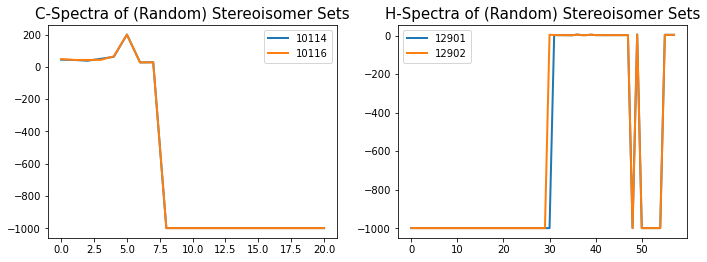

In [78]:
# How different are the spectra of these stereoisomers?

fig,ax = plt.subplots(1,2)

index = np.random.randint(0, len(stereoisomer_indices_C)-1)
example_isomers_C = stereoisomer_indices_C[index]
example_spectra = data_df_C.loc[example_isomers_C].spectrum_C
for i, spec in enumerate(example_spectra):
    ax[0].plot(spec, linewidth = 2, label = example_isomers_C[i])

ax[0].legend()
ax[0].set_title('C-Spectra of (Random) Stereoisomer Sets', fontsize = 15)

index = np.random.randint(0, len(stereoisomer_indices_H)-1)
example_isomers_H = stereoisomer_indices_H[index]
example_spectra = data_df_H.loc[example_isomers_H].spectrum_H
for i, spec in enumerate(example_spectra):
    ax[1].plot(spec, linewidth = 2, label = example_isomers_H[i])
    
ax[1].legend()
ax[1].set_title('H-Spectra of (Random) Stereoisomer Sets', fontsize = 15)

fig.set_figheight(4)
fig.set_figwidth(10)
fig.tight_layout(pad=2)
plt.show()

## How diverse are the molecules in each dataset? Are the datasets comparable?

### Comparing distributions of molecular weight and number of chiral centers in each dataset

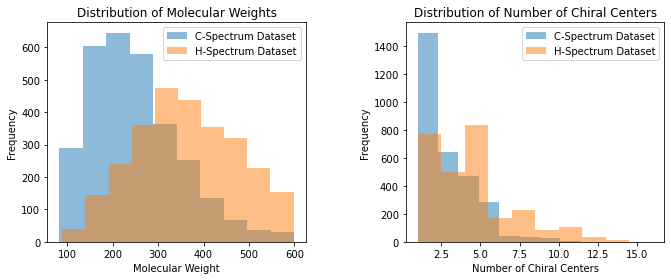

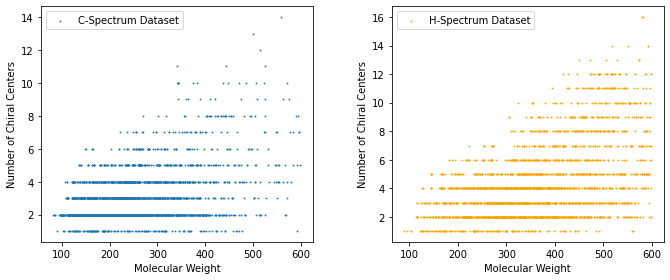

In [33]:
# General Molecular-Level Statistics of Each Dataset

#Histrograms of Molecular Weights and Chiral Centers
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(data_df_C['MW'], alpha = 0.5, label = 'C-Spectrum Dataset')
ax[0].hist(data_df_H['MW'], alpha = 0.5, label = 'H-Spectrum Dataset')
ax[0].legend()
ax[0].set_title('Distribution of Molecular Weights')
ax[0].set_xlabel('Molecular Weight')
ax[0].set_ylabel('Frequency')

ax[1].hist(data_df_C['num_chiral'], alpha = 0.5, label = 'C-Spectrum Dataset')
ax[1].hist(data_df_H['num_chiral'], alpha = 0.5, label = 'H-Spectrum Dataset')
ax[1].legend()
ax[1].set_title('Distribution of Number of Chiral Centers')
ax[1].set_xlabel('Number of Chiral Centers')
ax[1].set_ylabel('Frequency')
fig.tight_layout()
fig.set_figheight(4)
fig.set_figwidth(10)
plt.show()

#Scatterplots of Molecular Weights vs. Chiral Centers
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].scatter(data_df_C['MW'], data_df_C['num_chiral'], s = 0.7, label = 'C-Spectrum Dataset')
ax[0].legend()
ax[0].set_xlabel('Molecular Weight')
ax[0].set_ylabel('Number of Chiral Centers')

ax[1].scatter(data_df_H['MW'], data_df_H['num_chiral'], s = 0.7, color = 'orange', label = 'H-Spectrum Dataset')
ax[1].legend()
ax[1].set_xlabel('Molecular Weight')
ax[1].set_ylabel('Number of Chiral Centers')
fig.tight_layout()
fig.set_figheight(4)
fig.set_figwidth(10)
plt.show()


### Comparing distributions of molecular descriptors (from RDKit) in each dataset

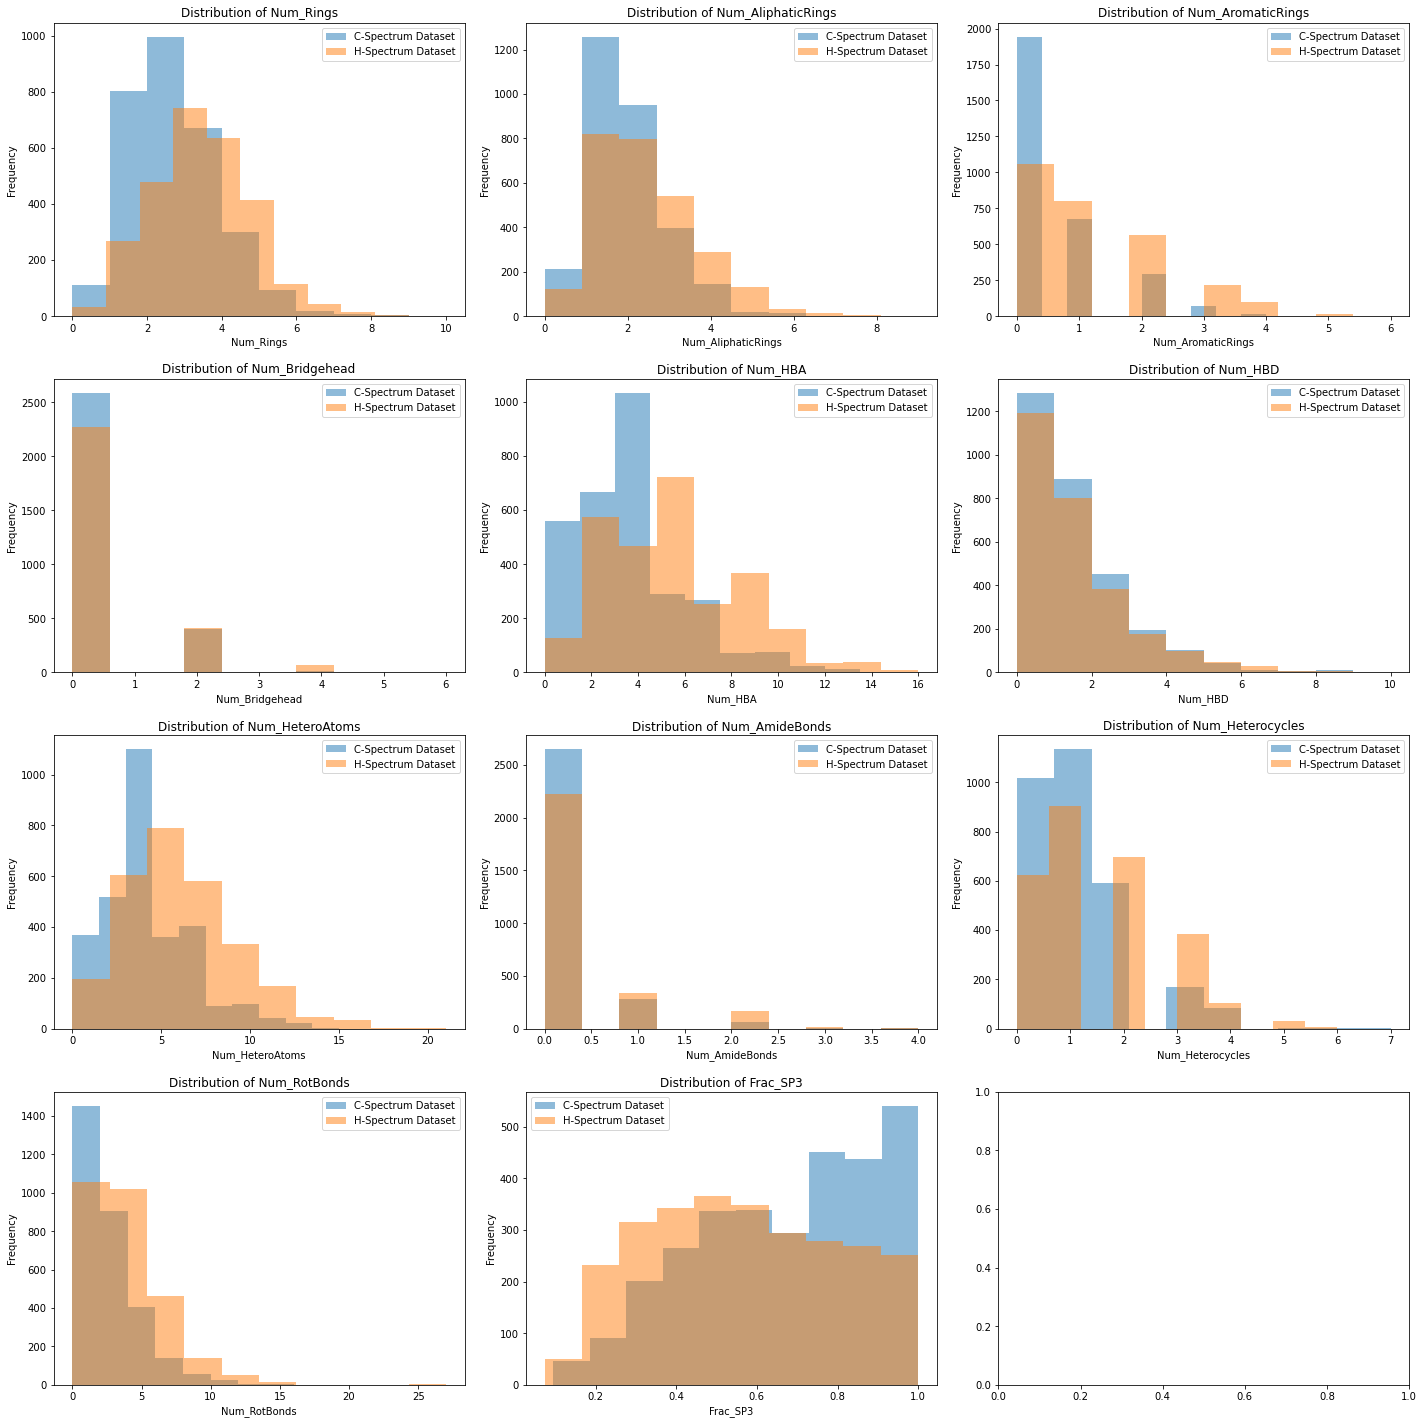

In [64]:
# Histograms of # of rings, atom types, number of atoms, etc.

descriptors_df_C = pd.DataFrame([[
    rdMolDescriptors.CalcNumRings(mol),
    rdMolDescriptors.CalcNumAliphaticRings(mol),
    rdMolDescriptors.CalcNumAromaticRings(mol),
    rdMolDescriptors.CalcNumBridgeheadAtoms(mol),
    rdMolDescriptors.CalcNumHBA(mol),
    rdMolDescriptors.CalcNumHBD(mol),
    rdMolDescriptors.CalcNumHeteroatoms(mol),
    rdMolDescriptors.CalcNumAmideBonds(mol),
    rdMolDescriptors.CalcNumHeterocycles(mol),
    rdMolDescriptors.CalcNumRotatableBonds(mol),
    rdMolDescriptors.CalcFractionCSP3(mol)
    ] for mol in mols_nostereo_C])
descriptors_df_C.columns = ['Num_Rings', 
                            'Num_AliphaticRings', 
                            'Num_AromaticRings', 
                            'Num_Bridgehead', 
                            'Num_HBA', 
                            'Num_HBD', 
                            'Num_HeteroAtoms', 
                            'Num_AmideBonds', 
                            'Num_Heterocycles', 
                            'Num_RotBonds',
                            'Frac_SP3'
                            ]

descriptors_df_H = pd.DataFrame([[
    rdMolDescriptors.CalcNumRings(mol),
    rdMolDescriptors.CalcNumAliphaticRings(mol),
    rdMolDescriptors.CalcNumAromaticRings(mol),
    rdMolDescriptors.CalcNumBridgeheadAtoms(mol),
    rdMolDescriptors.CalcNumHBA(mol),
    rdMolDescriptors.CalcNumHBD(mol),
    rdMolDescriptors.CalcNumHeteroatoms(mol),
    rdMolDescriptors.CalcNumAmideBonds(mol),
    rdMolDescriptors.CalcNumHeterocycles(mol),
    rdMolDescriptors.CalcNumRotatableBonds(mol),
    rdMolDescriptors.CalcFractionCSP3(mol)
    ] for mol in mols_nostereo_H])

descriptors_df_H.columns = ['Num_Rings', 
                            'Num_AliphaticRings', 
                            'Num_AromaticRings', 
                            'Num_Bridgehead', 
                            'Num_HBA', 
                            'Num_HBD', 
                            'Num_HeteroAtoms', 
                            'Num_AmideBonds', 
                            'Num_Heterocycles', 
                            'Num_RotBonds',
                            'Frac_SP3'
                            ]

fig, ax = plt.subplots(nrows=4, ncols=3)

for index, feature in enumerate(descriptors_df_H.columns):
    col = (index) % 3
    row = math.floor((index)/3)

    ax[row, col].hist(descriptors_df_C[feature], alpha = 0.5, label = 'C-Spectrum Dataset')
    ax[row, col].hist(descriptors_df_H[feature], alpha = 0.5, label = 'H-Spectrum Dataset')
    ax[row, col].legend()
    t = 'Distribution of ' + feature
    ax[row, col].set_title(t)
    ax[row, col].set_xlabel(feature)
    ax[row, col].set_ylabel('Frequency')

fig.set_figheight(20)
fig.set_figwidth(20)
fig.tight_layout(pad=1.5)
plt.show()